# bmorph Tutorial: Getting your first bias corrections
This notebook demonstrates how to setup data for and bias correct it through bmorph, it contains the same information as the [tutorial](bmorph_tutorial.rst) page.
In this notebook, we will demonstrate how to perform four variations of bias correction. For more information about the details of each method refer to the [bias correction page](https://bmorph.readthedocs.io/en/latest/bias_correction.html) page. The rest of the documentation for bmorph can be found [here](https://bmorph.readthedocs.io/en/latest/index.html).

* Independent Bias Correction: Univariate (IBC_U) : IBC_U is the traditional bias correction method. This method can only be performed at sites with reference data.
* Independent Bias Correction: Conditioned (IBC_C) : IBC_C allows for correcting for specific biases that are process-dependent. This method can only be performed at sites with reference data.
* Spatially Consistent Bias Correction: Univariate (SCBC_U): SCBC_U corrects local flows at each river reach in the network, and then reroutes them to aggregate, producing bias corrected flows everywhere.
* Spatially Consistent Bias Correction: Conditioned (SCBC_C): SCBC_C also corrects the local flows like SCBC_U, but allows for conditioning on dependent processes.

# Expectations using this Tutorial

Before we begin, we are expecting that anyone using this notebook is already familiar with the following:

- Python 3 syntax and logic
- [Jupyter Notebooks](https://jupyterlab.readthedocs.io/en/stable/user/notebook.html)
- [numpy](https://numpy.org/)
- [pandas](https://pandas.pydata.org/)
- [xarray](http://xarray.pydata.org/en/stable/)
- [matplotlib](https://matplotlib.org/)
- [mizuRoute](https://mizuroute.readthedocs.io/en/latest/)


This tutorial also makes use of a number of other open source libraries & programs which, although no familiarity is required, may be of interest:
- [geopandas](https://geopandas.org/)
- [tqdm](https://tqdm.github.io/)
- [dask](https://dask.org/)
- [networkx](https://networkx.org/)
- [scipy](https://www.scipy.org/)
- [scikit-learn](https://scikit-learn.org/stable/)

While proficiency with each item is not required to understand the notebook, the details of these items will not be included in the tutorial itself.

# Learning objectives & goals

By the end of this tutorial you will learn

- The data requirements to perform bias corrections with bmorph
- Input and output formats that bmorph expects
- The meaning of parameters for algorithmic control of bias corrections
- How to perform independent bias correction at locations with reference flows
- How to perform spatially consistent bias corrections across a river network, as well as rerouting the corrected flows with mizuRoute
- How to use the analysis, evaluation, and visualization tools built into bmorph

We expect that this tutorial will take approximately half an hour for someone familiar with Python.

# Import Packages and Load Data

We start by importing the necessary packages for the notebook.
This tutorial mainly shows how to use ``bmorph.core.workflows`` and ``bmorph.core.mizuroute_utils`` to bias correct streamflow data in the Yakima river basin.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from dask.distributed import Client, progress

# Set a bigger default plot size
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['font.size'] = 22

# Import bmorph, and mizuroute utilities
import bmorph
from bmorph.util import mizuroute_utils as mizutil
from bmorph.evaluation.simple_river_network import SimpleRiverNetwork
from bmorph.evaluation import plotting as bplot

# Set the environment directory, this is a workaround for portability
envdir = os.path.dirname(sys.executable)

# Import pyproj and set the data directory, this is a workaround for portability
import pyproj
pyproj.datadir.set_data_dir(f'{envdir}/../share/proj')

Populating the interactive namespace from numpy and matplotlib



## Getting the sample data

The following code cell has two commands preceded by `!`, which indicates that they are shell command. They will download the sample data and unpackage it. The sample data can be viewed as a HydroShare resource [here](https://www.hydroshare.org/resource/fd2a347d34f145b4bfa8b6bff39c782b/). This cell may take a few moments.

In [2]:
! wget https://www.hydroshare.org/resource/fd2a347d34f145b4bfa8b6bff39c782b/data/contents/bmorph_testdata.tar.gz
! tar xvf bmorph_testdata.tar.gz

--2021-07-01 16:08:12--  https://www.hydroshare.org/resource/fd2a347d34f145b4bfa8b6bff39c782b/data/contents/bmorph_testdata.tar.gz
Resolving www.hydroshare.org (www.hydroshare.org)... 152.54.2.89
Connecting to www.hydroshare.org (www.hydroshare.org)|152.54.2.89|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /resource/fd2a347d34f145b4bfa8b6bff39c782b/data/contents/bmorph_testdata.tar.gz/ [following]
--2021-07-01 16:08:12--  https://www.hydroshare.org/resource/fd2a347d34f145b4bfa8b6bff39c782b/data/contents/bmorph_testdata.tar.gz/
Reusing existing connection to www.hydroshare.org:443.
HTTP request sent, awaiting response... 302 Found
Location: /django_irods/rest_download/fd2a347d34f145b4bfa8b6bff39c782b/data/contents/bmorph_testdata.tar.gz/?url_download=False&zipped=False&aggregation=False [following]
--2021-07-01 16:08:12--  https://www.hydroshare.org/django_irods/rest_download/fd2a347d34f145b4bfa8b6bff39c782b/data/contents/bmorph_testdata.tar.

# Test dataset: The Yakima River Basin

Before getting into how to run bmorph, let's look at what is in the sample data. You will note that we now have a `yakima_workflow` directory. This contains all of the data that you need to run the tutorial. There are a few subdirectories:

 * `gis_data`: contains shapefiles, this is mainly used for plotting, not for analysis
 * `input`: this is the input meteorologic data, simulated streamflow to be corrected, and the reference flow dataset
 * `mizuroute_configs`: this is an empty directory that will automatically be populated with mizuroute configuration files during the bias correction process
 * `output`: this is an empty directory that will be where the bias corrected flows will be written out to
 * `topologies`: this contains the stream network topologies that will be used for routing flows via mizuroute


The Yakima river basin is a tributary of the Columbia river basin in the Pacific northwestern United States. It's western half is situated in the Cascade mountains and receives seasonal snowpack. The eastern half is lower elevation and is semi-arid. Let's load up the shapefiles for the sub-basins and stream network and plot it. In this discretization we have 285 sub-basins (HRU) and 143 stream segments.

# Setting up some metadata

Next we set up the gauge site names and their respective river segment identification
numbers, or `site`'s and `seg`'s. This will be used throughout to ensure the data does
not get mismatched. bmorph uses the convention:
`site_to_seg = { site_0_name : site_0_seg, ..., site_n_name, site_n_seg}`
Since it is convenient to be able to access this data in different orders we also set up 
some other useful forms of these gauge site mappings for later use. We will show you on the map where each of these sites are on the stream network in the next section.

In [3]:
site_to_seg = {'KEE' : 4175, 'KAC' : 4171, 'EASW': 4170, 
               'CLE' : 4164, 'YUMW': 4162, 'BUM' : 5231,
               'AMRW': 5228, 'CLFW': 5224, 'RIM' : 5240,
               'NACW': 5222, 'UMTW': 4139, 'AUGW': 594,  
               'PARW': 588,  'YGVW': 584,  'KIOW': 581}

seg_to_site = {seg: site for site, seg in site_to_seg.items()}
ref_sites = list(site_to_seg.keys())
ref_segs = list(site_to_seg.values())    

# Mapping the Yakima river basin

With our necessary metadata defined let's make a couple of quick plots orienting you to the Yakima river basin. To do so we will read in a network topology file, and shapefiles for the region. We will make one plot which has the Yakima river basin, along with stream network, subbasins, and gauged sites labeled. We will also plot a network diagram which displays in an abstract sense how each stream segment is connected. For the latter we use the [SimpleRiverNetwork](https://bmorph.readthedocs.io/en/latest/srn.html) that we've implemented in bmorph. To set up the `SimpleRiverNetwork` we the topology of the watershed (`yakima_topo`). The river network and shapefiles that we use to draw the map, and perform simulations on is the [Geospatial Fabric](        https://doi.org/10.5066/P971JAGF). The locations of the gauged sites are shown in red, while all of the un-gauged stream segments are shown in darker grey. The sub-basins for each stream segment are shown in lighter grey.

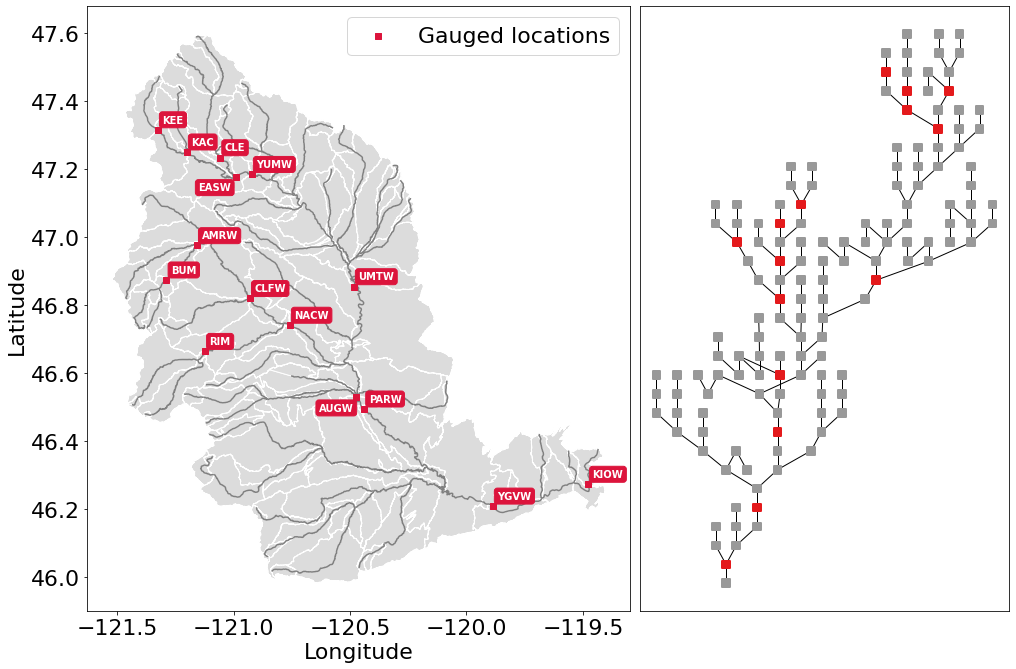

In [5]:
yakima_topo = xr.open_dataset('yakima_workflow/topologies/yakima_huc12_topology.nc').load()
yakima_hru = gpd.read_file('./yakima_workflow/gis_data/yakima_hru.shp').to_crs("EPSG:4326")
yakima_seg = gpd.read_file('./yakima_workflow/gis_data/yakima_seg.shp').to_crs("EPSG:4326")

fig, axes = plt.subplots(1, 2, figsize=(14, 9), gridspec_kw={'width_ratios': [1.5, 1]})
axes[1].invert_xaxis() # flip makes nodes line up better with map

# Plot the subbasins and stream segments
ax = yakima_hru.plot(color='gainsboro', edgecolor='white', ax=axes[0])
yakima_seg.plot(ax=ax, color='grey')

# Plot the reference flow sites
ref_lats = yakima_seg[yakima_seg['seg_id'].isin(ref_segs)]['end_lat']
ref_lons = yakima_seg[yakima_seg['seg_id'].isin(ref_segs)]['end_lon']
ref_names = [seg_to_site[s] for s in yakima_seg[yakima_seg['seg_id'].isin(ref_segs)]['seg_id']]
ax.scatter(ref_lons, ref_lats, color='crimson', zorder=100, marker='s', label='Gauged locations')
for name, lat, lon in zip(ref_names, ref_lats, ref_lons):
    if name in ['AUGW', 'EASW']:
        # Set labels at a slightly different position so we don't have overlaps
        offset_x, offset_y = -0.16, -0.04
    else:
        offset_x, offset_y = 0.02, 0.02
    ax.text(lon+offset_x, lat+offset_y, name, fontsize=10, color='white', weight='bold',
            bbox=dict(boxstyle="round", ec='crimson', fc='crimson', ),)
ax.legend()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Now plot the abstracted river network, with gauged sites highlighted
yakima_srn = SimpleRiverNetwork(yakima_topo)
yakima_srn.draw_network(color_measure=yakima_srn.generate_node_highlight_map(ref_segs), 
                        cmap=mpl.cm.get_cmap('Set1_r'), ax=axes[1], node_size=60)
plt.tight_layout(pad=0)

# Loading in the streamflow data and associated meteorological data

Now we load in the meteorological data that will be used for conditional bias correction: daily minimum temperature (`tmin`), seasonal precipitation (`prec`),
and daily maximum temperature (`tmax`). In principle, any type of data can be used for conditioning. This data is initially arranged on the sub-basins, rather than stream segments. We will remap these onto the stream segments in a moment, so that they can be used in the bias correction process.

Finally, we load the simulated flows and reference flows. 
bmorph is designed to bias correct streamflow simulated with [mizuroute](https://mizuroute.readthedocs.io/en/latest/). 
We denote the simulated flows as the "raw" flows when they are uncorrected, and the flows that will be used to correct the raw flows as the "reference" flows. During the bias correction process bmorph will map the raw flow values to the reference flow values by matching their quantiles. 
In our case the reference flows are estimated no-reservoir-no-irrigation (NRNI) flows taken from the [River Management Joint Operating Committee (RMJOC)](https://www.bpa.gov/p/Generation/Hydro/Documents/RMJOC-II_Part_II.PDF).

All of the datasets discussed are in the `xarray` [Dataset format](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataset), which contains the metadata associated with the original NetCDF files. You can inspect the data simply by printing it out. For instance, here you can see that both the reference flows and raw flows (named `IRFroutedRunoff`, for "Impulse Response Function routed runoff" from mizuRoute) are in cubic meters per second.

In [6]:
# Meteorologic data
yakima_met = xr.open_dataset('yakima_workflow/input/yakima_met.nc').load()
# Remove the 17* prefix, which was used to denote the domain covers the region 17 of the Hydrologic Unit Maps
yakima_met['hru'] = (yakima_met['hru'] - 1.7e7).astype(np.int32)

# Raw streamflows
yakima_raw = xr.open_dataset('yakima_workflow/input/yakima_raw_flows.nc')[['IRFroutedRunoff', 'dlayRunoff', 'reachID']].load()
# Update some metadata
yakima_raw['seg'] = yakima_raw.isel(time=0)['reachID'].astype(np.int32)

# Reference streamflows - this contains sites from the entire Columbia river basin, but we will select out only the `ref_sites`
yakima_ref = xr.open_dataset('yakima_workflow/input/nrni_reference_flows.nc').rename({'outlet':'site'})[['seg', 'seg_id', 'reference_flow']]
# Pull out only the sites in the Yakima basin
yakima_ref = yakima_ref.sel(site=ref_sites).load()

print('Reference flow units: ', yakima_ref['reference_flow'].units)
print('Raw flow units: ', yakima_raw['IRFroutedRunoff'].units)

Reference flow units:  m3/s
Raw flow units:  m3/s


## Convert from ``mizuroute`` output to ``bmorph`` format

``mizuroute_utils`` is our utility module that will handle converting mizuroute outputs to the format that we need for ``bmorph``. 
We will use the `mizutil.to_bmorph` function to merge together all of the data we previously loaded, and calculate some extra pieces of information to perform spatially consistent bias corrections (SCBC).
For more information about how we perform SCBC see [the SCBC page in the documentation](https://bmorph.readthedocs.io/en/develop/bias_correction.html#spatial-consistency-reference-site-selection-cdf-blend-factor).
Now we pass our data in to ``to_bmorph``, the primary utility function for automating ``bmorph`` pre-processing.

In [7]:
yakima_met_seg = mizutil.to_bmorph(yakima_topo, yakima_raw, yakima_ref, yakima_met,  fill_method='r2')

## Setting up ``bmorph`` configuration and parameters

Before applying bias correction we need to specify some parameters and configuration
for correction. Returning to these steps can help fine tune your bias 
corrections to the basin you are analyzing.

The ``train_window`` is what we will use to train the bias correction
model. This is the time range that is representative of the
basin's expected behavior that ``bmorph`` should mirror.

The ``bmorph_window`` is when ``bmorph`` should be applied to the series for
bias correction.

Lastly the ``reference_window`` is when the reference flows should be used to 
smooth the Cumulative Distribution function (CDF) of the bias corrected flows. 
This is recommended to be set as equivalent to the ``train_window``.

In [8]:
train_window = pd.date_range('1981-01-01', '1990-12-30')[[0, -1]]
reference_window = train_window
apply_window= pd.date_range('1991-01-01', '2005-12-30')[[0, -1]]

``interval`` is the length of ``bmorph``'s application intervals, 
typically a factor of years to preserve hydrologic 
relationships. Note that for ``pandas.DateOffset``, 'year' and 'years' 
are different and an 's' should always be included here for ``bmorph``
to run properly, even for a single year.

``overlap`` describes how many days the bias correction cumulative distribution function
windows should overlap in total with each other. ``overlap`` is evenly distributed before
and after this window. This is used to reduce discontinuities between application periods.
Typical values are between 60 and 120 days.

The two "smoothing" parameters are used to smooth the timeseries before the CDFs are computed
and have two different uses. THe `n_smooth_short` is used in the actual calculation of the CDFs which are used to perform the quantile mapping. Smoothing is used to ensure that the CDFs are smooth. Setting a very low value here may cause noisier bias corrected timeseries. Setting a very high value may cause the bias corrections to not match extreme flows. Typical values are from 7-48 days.

`n_smooth_long` on the other hand is used to preserve long-term trends in mean flows from the raw flows. Typical values are 270 to 720 days. Using very low values may cause bias corrections to be degraded. This feature can be turned off by setting `n_smooth_long` to `None`.

``condition_var`` names the variable to use in conditioning, such as maximum
temperature (tmax), 90 day rolling total precipitation (seasonal_precip), or daily
minimum temperature (tmin). At this time, only one conditioning
meteorological variable can be used per ``bmorph`` execution. In this example,
``tmax`` and ``seasonal_precip`` have been commented out to select ``tmin`` as
the conditioning variable. We have precomputed the ``seasonal_precip`` to be If you wish to change this, be sure to either change which variables are commented out or change the value of ``condition_var`` itself. For now we will just use `tmin`, which is the daily minimum temperature. Our hypothesis on choosing `tmin` is that it will be a good indicator for errors in snow processes, which should provide a good demonstration for how conditional bias correction can modify flow timing in desirable ways.

In [9]:
# bmorph parameter values
interval = pd.DateOffset(years=5)
overlap = 90
n_smooth_long = 365
n_smooth_short = 21

# Select from the various available meteorologic fields for conditioning
#condition_var = 'tmax'
#condition_var = 'seasonal_precip'
condition_var = 'tmin'

Here we name some configuration parameters for ``bmorph``'s conditional and univariate
bias correction methods, respectively. 

``output_prefix`` will be used to write and load files according to the
basin's name, make certain to update this with the actual name of
the basin you are analyzing so you can track where different files
are written.

In [62]:
conditional_config = {
    'data_path':  './yakima_workflow',
    'output_prefix': "yakima",
    'raw_train_window': train_window,
    'ref_train_window': reference_window,
    'apply_window': apply_window,
    'bmorph_interval': interval,
    'bmorph_overlap': overlap,
    'n_smooth_long': n_smooth_long,
    'n_smooth_short': n_smooth_short,
    'condition_var': condition_var,
    'method': 'hist',
    'xbins': 100,
    'ybins': 100,
}

univariate_config = {
    'data_path':  './yakima_workflow',
    'output_prefix': "yakima",
    'raw_train_window': train_window,
    'ref_train_window': reference_window,
    'apply_window': apply_window,
    'bmorph_interval': interval,
    'bmorph_overlap': overlap,
    'n_smooth_long': n_smooth_long,
    'n_smooth_short': n_smooth_short,
}

You made it! Now we can actually bias correction with ``bmorph``! 

First off we run the Independent Bias Corrections, which are completely contained
in the cell below. 

Here we run through each of the gauge sites and correct them 
individually. Since independent bias correction can only be performed
at locations with reference data, corrections are only performed at
the gauge sites here. 

## Independent bias correction

In [63]:
ibc_u_flows = {}
ibc_u_mults = {}
ibc_c_flows = {}
ibc_c_mults = {}
cond_vars = {}

raw_flows = {}
ref_flows = {}
for site, seg in tqdm(site_to_seg.items()):
    raw_ts =   yakima_met_seg.sel(seg=seg)['IRFroutedRunoff'].to_series()
    train_ts = yakima_met_seg.sel(seg=seg)['IRFroutedRunoff'].to_series()
    obs_ts =   yakima_met_seg.sel(seg=seg)['up_ref_flow'].to_series()
    cond_var = yakima_met_seg.sel(seg=seg)[f'up_{condition_var}'].to_series()
    ref_flows[site] = obs_ts
    raw_flows[site] = raw_ts
    cond_vars[site] = cond_var

    ## IBC_U (Independent Bias Correction: Univariate)
    ibc_u_flows[site], ibc_u_mults[site] = bmorph.workflows.apply_bmorph(
        raw_ts, train_ts, obs_ts, **univariate_config)

    ## IBC_C (Independent Bias Correction: Conditioned)
    ibc_c_flows[site], ibc_c_mults[site] = bmorph.workflows.apply_bmorph(
        raw_ts, train_ts, obs_ts, condition_ts=cond_var, **conditional_config)

  0%|          | 0/15 [00:00<?, ?it/s]

# Spatially consistent bias correction

Here we specify where the ``mizuroute`` executable is installed on your system.

In [64]:
mizuroute_exe = f'{envdir}/route_runoff.exe'

Now we use ``run_parallel_scbc`` to do the rest. 
In the first cell we will run the spatially-consistent bias correction without any conditioning. 
The second cell will run the spatially-consistent bias correction with conditioning.
This produced bias corrected flows at all 143 stream segments in the Yakima river basin.
Finally, we select out the corrected streamflows for both cases (with and without conditioning) to only contain the gauged sites.
Selecting out only the gauged locations allows us to compare the spatially-consistent methods with the independent bias corrections.
Finally we combine all the data into a single xarray `Dataset` to make analysis easier.

In [65]:
# SCBC without conditioning
unconditioned_seg_totals = bmorph.workflows.apply_scbc(yakima_met_seg, mizuroute_exe, univariate_config)

  0%|          | 0/143 [00:00<?, ?it/s]

In [66]:
# SCBC with conditioning
conditioned_seg_totals = bmorph.workflows.apply_scbc(yakima_met_seg, mizuroute_exe, conditional_config)

  0%|          | 0/143 [00:00<?, ?it/s]

In [67]:
# Here we select out our rerouted gauge site modeled flows.
unconditioned_site_totals = {}
conditioned_site_totals = {}
for site, seg in tqdm(site_to_seg.items()):
    unconditioned_site_totals[site] = unconditioned_seg_totals['IRFroutedRunoff'].sel(seg=seg).to_series()
    conditioned_site_totals[site] = conditioned_seg_totals['IRFroutedRunoff'].sel(seg=seg).to_series()

  0%|          | 0/15 [00:00<?, ?it/s]

# Merging together the results

In [68]:
# Merge everything together
yakima_analysis = xr.Dataset(coords={'site': list(site_to_seg.keys()), 'time': unconditioned_seg_totals['time']})
yakima_analysis['scbc_c'] = bmorph.workflows.bmorph_to_dataarray(conditioned_site_totals, 'scbc_c')
yakima_analysis['scbc_u'] = bmorph.workflows.bmorph_to_dataarray(unconditioned_site_totals, 'scbc_u')
yakima_analysis['ibc_u'] = bmorph.workflows.bmorph_to_dataarray(ibc_u_flows, 'ibc_u')
yakima_analysis['ibc_c'] = bmorph.workflows.bmorph_to_dataarray(ibc_c_flows, 'ibc_c')
yakima_analysis['raw'] = bmorph.workflows.bmorph_to_dataarray(raw_flows, 'raw')
yakima_analysis['ref'] = bmorph.workflows.bmorph_to_dataarray(ref_flows, 'ref')
yakima_analysis.to_netcdf(f'./yakima_workflow/output/{univariate_config["output_prefix"]}_data_processed.nc')

In [69]:
# And also output it as some CSV files
yakima_analysis['scbc_c'].to_pandas().to_csv(f'./yakima_workflow/output/{univariate_config["output_prefix"]}_data_processed_scbc_c.csv')
yakima_analysis['scbc_u'].to_pandas().to_csv(f'./yakima_workflow/output/{univariate_config["output_prefix"]}_data_processed_scbc_u.csv')
yakima_analysis['ibc_u'].to_pandas().to_csv(f'./yakima_workflow/output/{univariate_config["output_prefix"]}_data_processed_ibc_u.csv')
yakima_analysis['ibc_c'].to_pandas().to_csv(f'./yakima_workflow/output/{univariate_config["output_prefix"]}_data_processed_ibc_u.csv')
yakima_analysis['raw'].to_pandas().to_csv(f'./yakima_workflow/output/{univariate_config["output_prefix"]}_data_processed_raw.csv')
yakima_analysis['ref'].to_pandas().to_csv(f'./yakima_workflow/output/{univariate_config["output_prefix"]}_data_processed_ref.csv')

## Now let's take a look at our results

If you look closely, the following plots are the same ones included in [Plotting](evaluation.rst/Plotting)! Because the plotting functions expect the variable `seg`, we will need to rename `site` to `seg` for them to properly run.

In [70]:
yakima_ds = xr.open_dataset(f'yakima_workflow/output/{univariate_config["output_prefix"]}_data_processed.nc')
yakima_ds = yakima_ds.rename({'site':'seg'})

Let's pick a few sites and colors to plot for consistency. To simplify our plots, we will only focus on `scbc_c` in the dataset we just created. The methods do allow for multiple methods to be compared at once however, so we will still need to store the singular `scbc_c` in a list.

In [71]:
select_sites = ['KIOW','YUMW','BUM']
select_sites_2 = ['KIOW','CLFW','BUM','UMTW']
bcs = ['scbc_c', 'scbc_u', 'ibc_c', 'ibc_u']
colors = ['grey', 'black', 'red', 'orange', 'purple', 'blue']

### Time Series

Here we plot the mean weekly flows for some of the sites in Yakima River Basin. You can change or add sites above, but we will start with a small number of sites to make the plots more tractable. In the following function call you 

As mentioned, these averages are computed on weekly intervals to simplify the figure, but can also be plotted on daily or monthly intervals for more or less granularity. You can also change the `reduce_func` to calculate any other statistic over the dataset (you might try `np.median` or `np.var` for instance). Don't forget to change the `statistic_label` for other measures!

(<Figure size 1440x864 with 4 Axes>, <AxesSubplot:title={'center':'UMTW'}>)

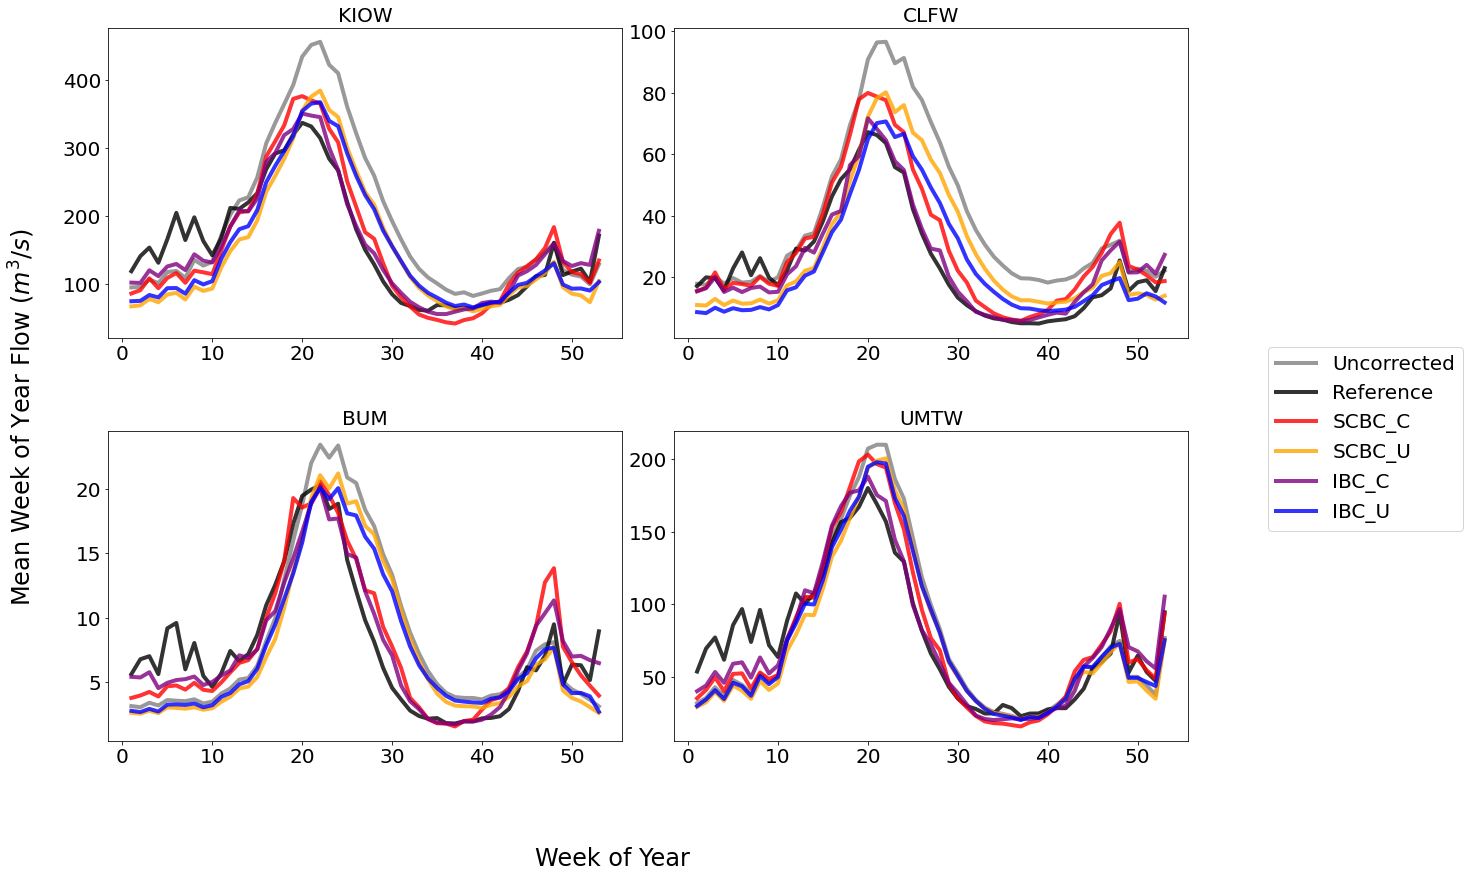

In [79]:
bplot.plot_reduced_flows(
    flow_dataset=yakima_ds, 
    plot_sites=select_sites_2, 
    interval='week',
    reduce_func=np.mean,
    statistic_label='Mean',
    raw_var='raw', raw_name="Uncorrected",
    ref_var='ref', ref_name="Reference",
    bc_vars=bcs, bc_names=[bc.upper() for bc in bcs],
    plot_colors=colors
)

From the plot above we can see that the conditional corrections (`x_C` methods) have more accurate flow timings, particularly during the falling limb of the hydrograph. This hints that our hypothesis on correcting on daily minimum temperature would provide a good proxy for correcting snowmelt biases. We will explore this a little bit more later.

We also see that generally the `SCBC_x` and `IBC_x` methods are fairly similar in the mean, with an exception at CLFW. This indicates that the spatially consistent bias correction produces useful bias corrections. The advantage of the SCBC method is that we produce bias corrections on every river reach, as well as produce bias corrected incremental flows which are consistent across the network.

### Scatter

This compares how absolute error changes through each bias correction with Q being stream discharge. 1 to 1 and -1 to 1 lines are plotted for reference, as points plotted vertically between the lines demonstrates a reduction in absolute error while points plotted horizontally between the lines demonstrates an increase in absolute error for each flow time.

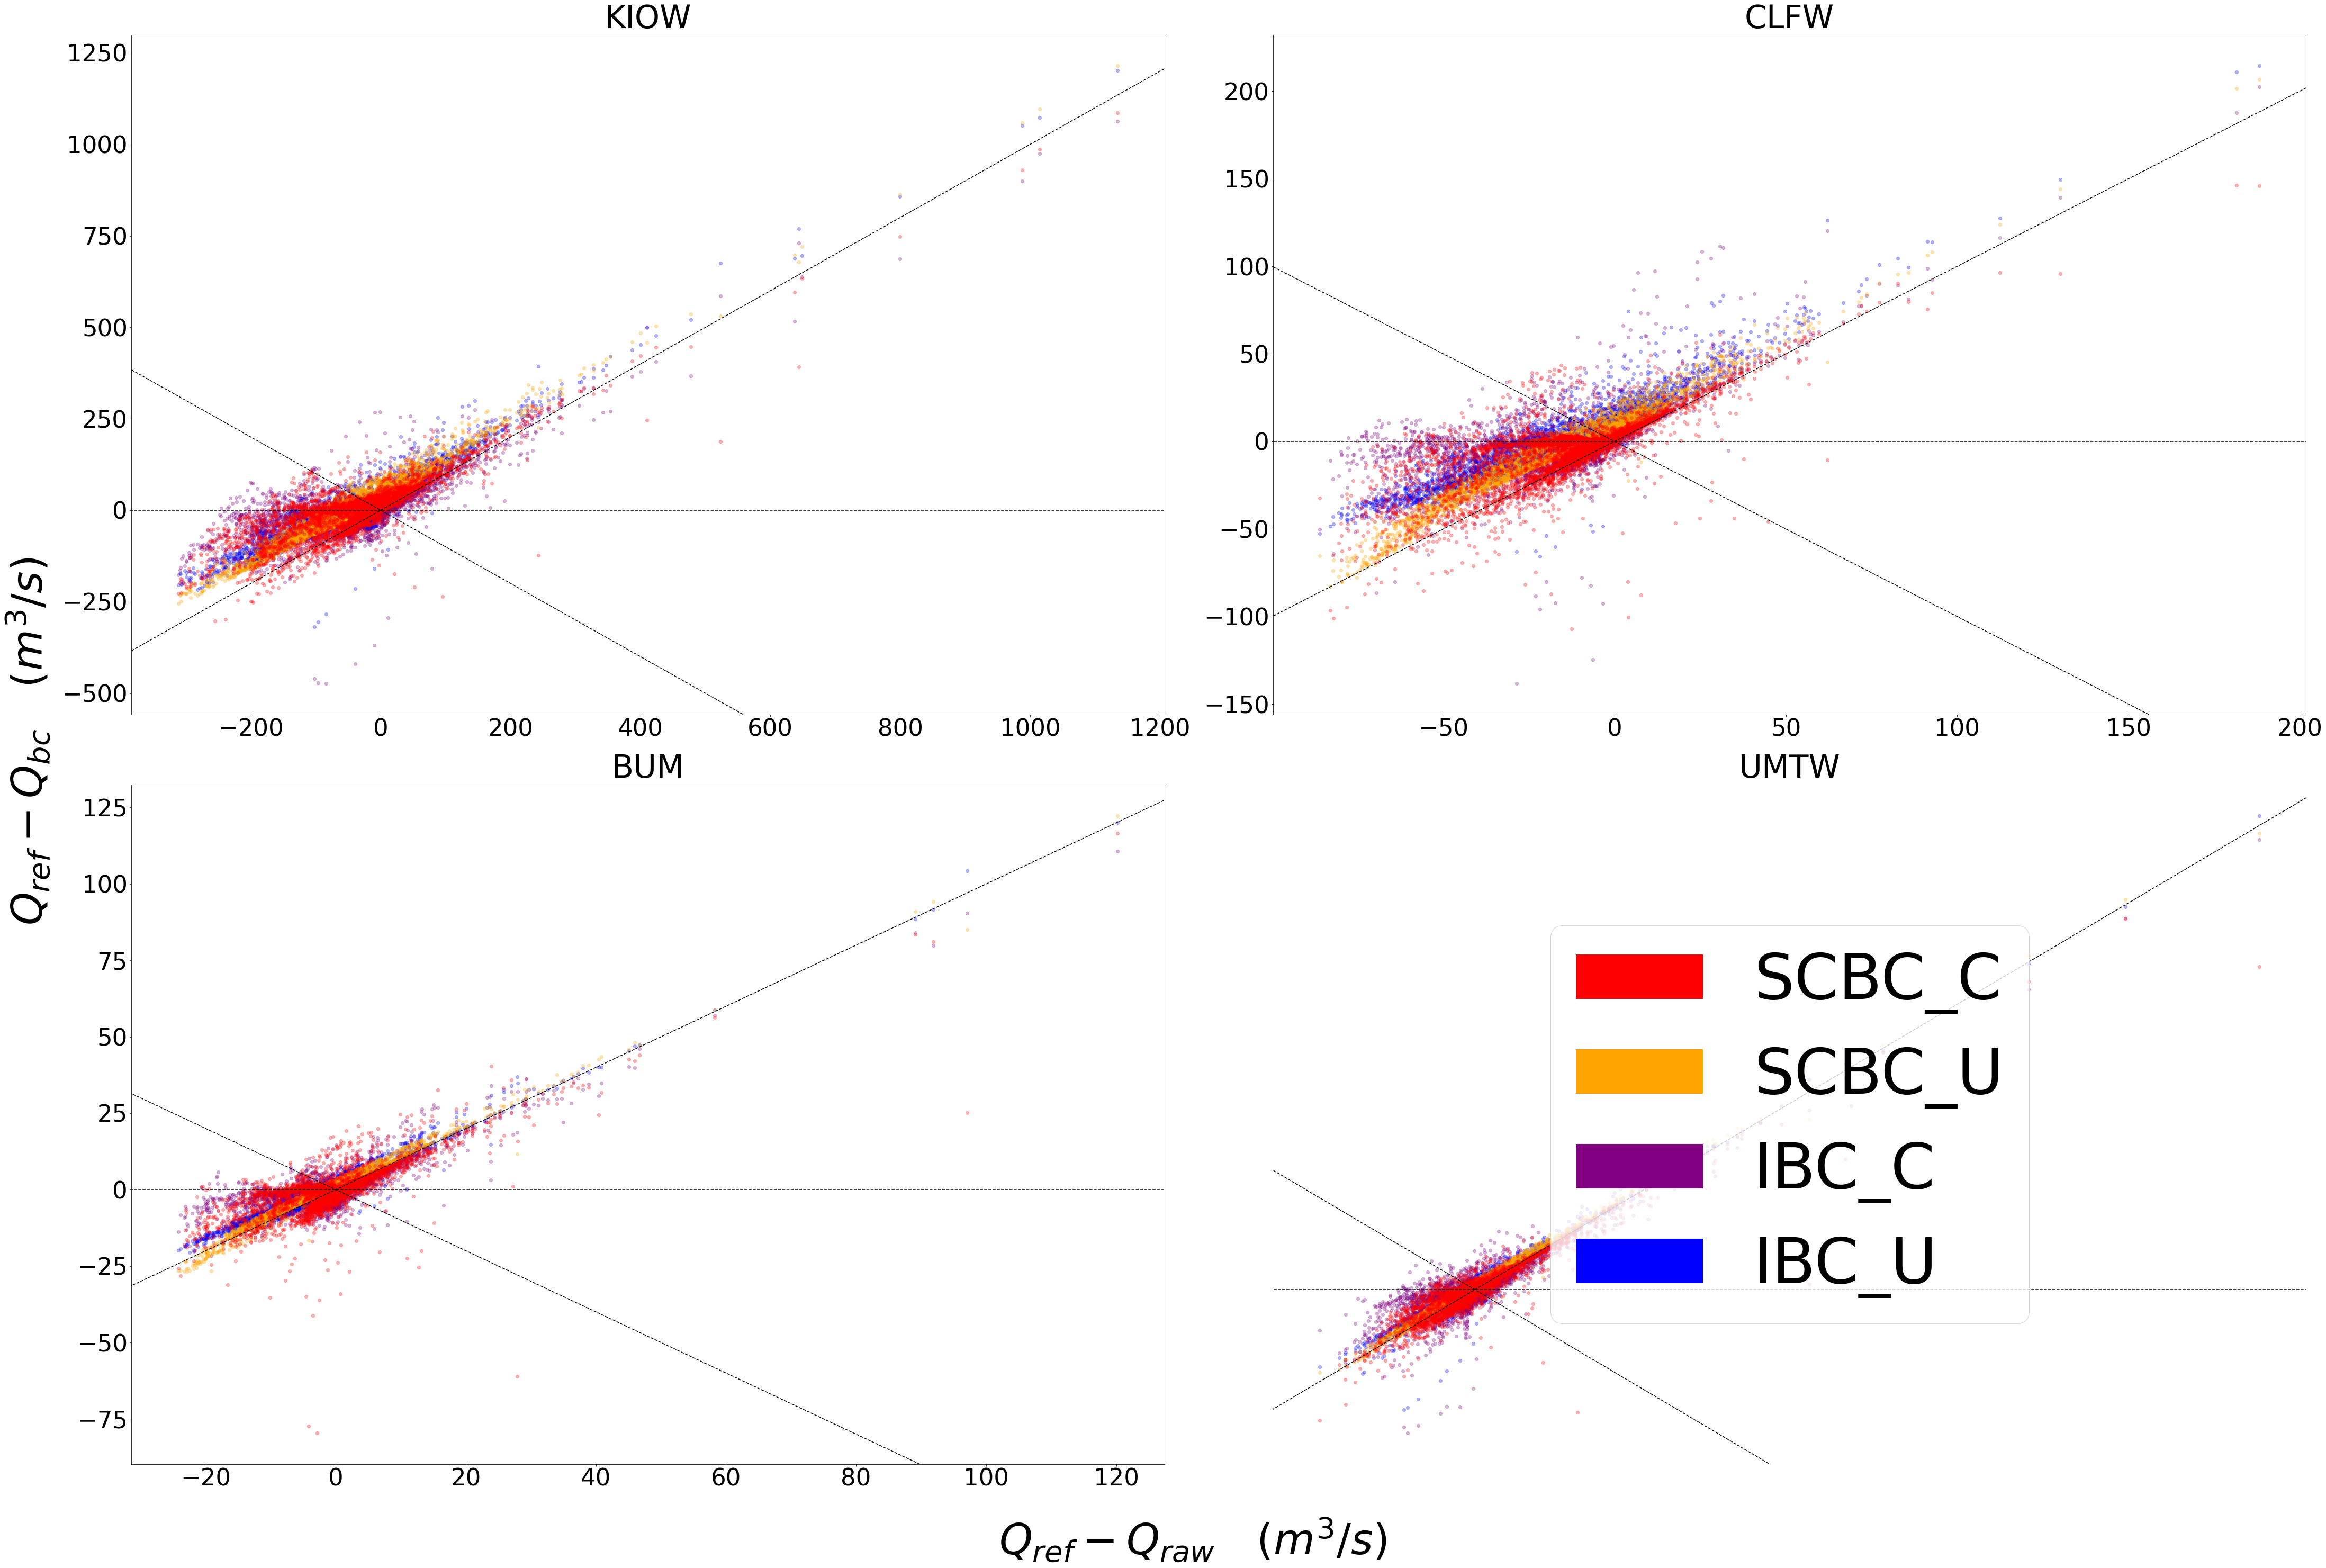

In [72]:
bplot.compare_correction_scatter(
    flow_dataset= yakima_ds, 
    plot_sites = select_sites_2,
    raw_var = 'raw', 
    ref_var = 'ref', 
    bc_vars = bcs, 
    bc_names = [bc.upper() for bc in bcs],
    plot_colors = list(colors[2:]),
    pos_cone_guide = True,
    neg_cone_guide = True,
    symmetry = False,
    title = '',
    fontsize_legend = 120,
    alpha = 0.3
)

### Probabilitiy Distribtutions

Since probability distributions are used to predict extreme flow events and are what ``bmorph`` directly corrects, looking at them will give us greater insight to the changes we made.

(<Figure size 4320x2880 with 4 Axes>,
 array([<AxesSubplot:title={'center':'KIOW'}>,
        <AxesSubplot:title={'center':'YUMW'}>,
        <AxesSubplot:title={'center':'BUM'}>, <AxesSubplot:>], dtype=object))

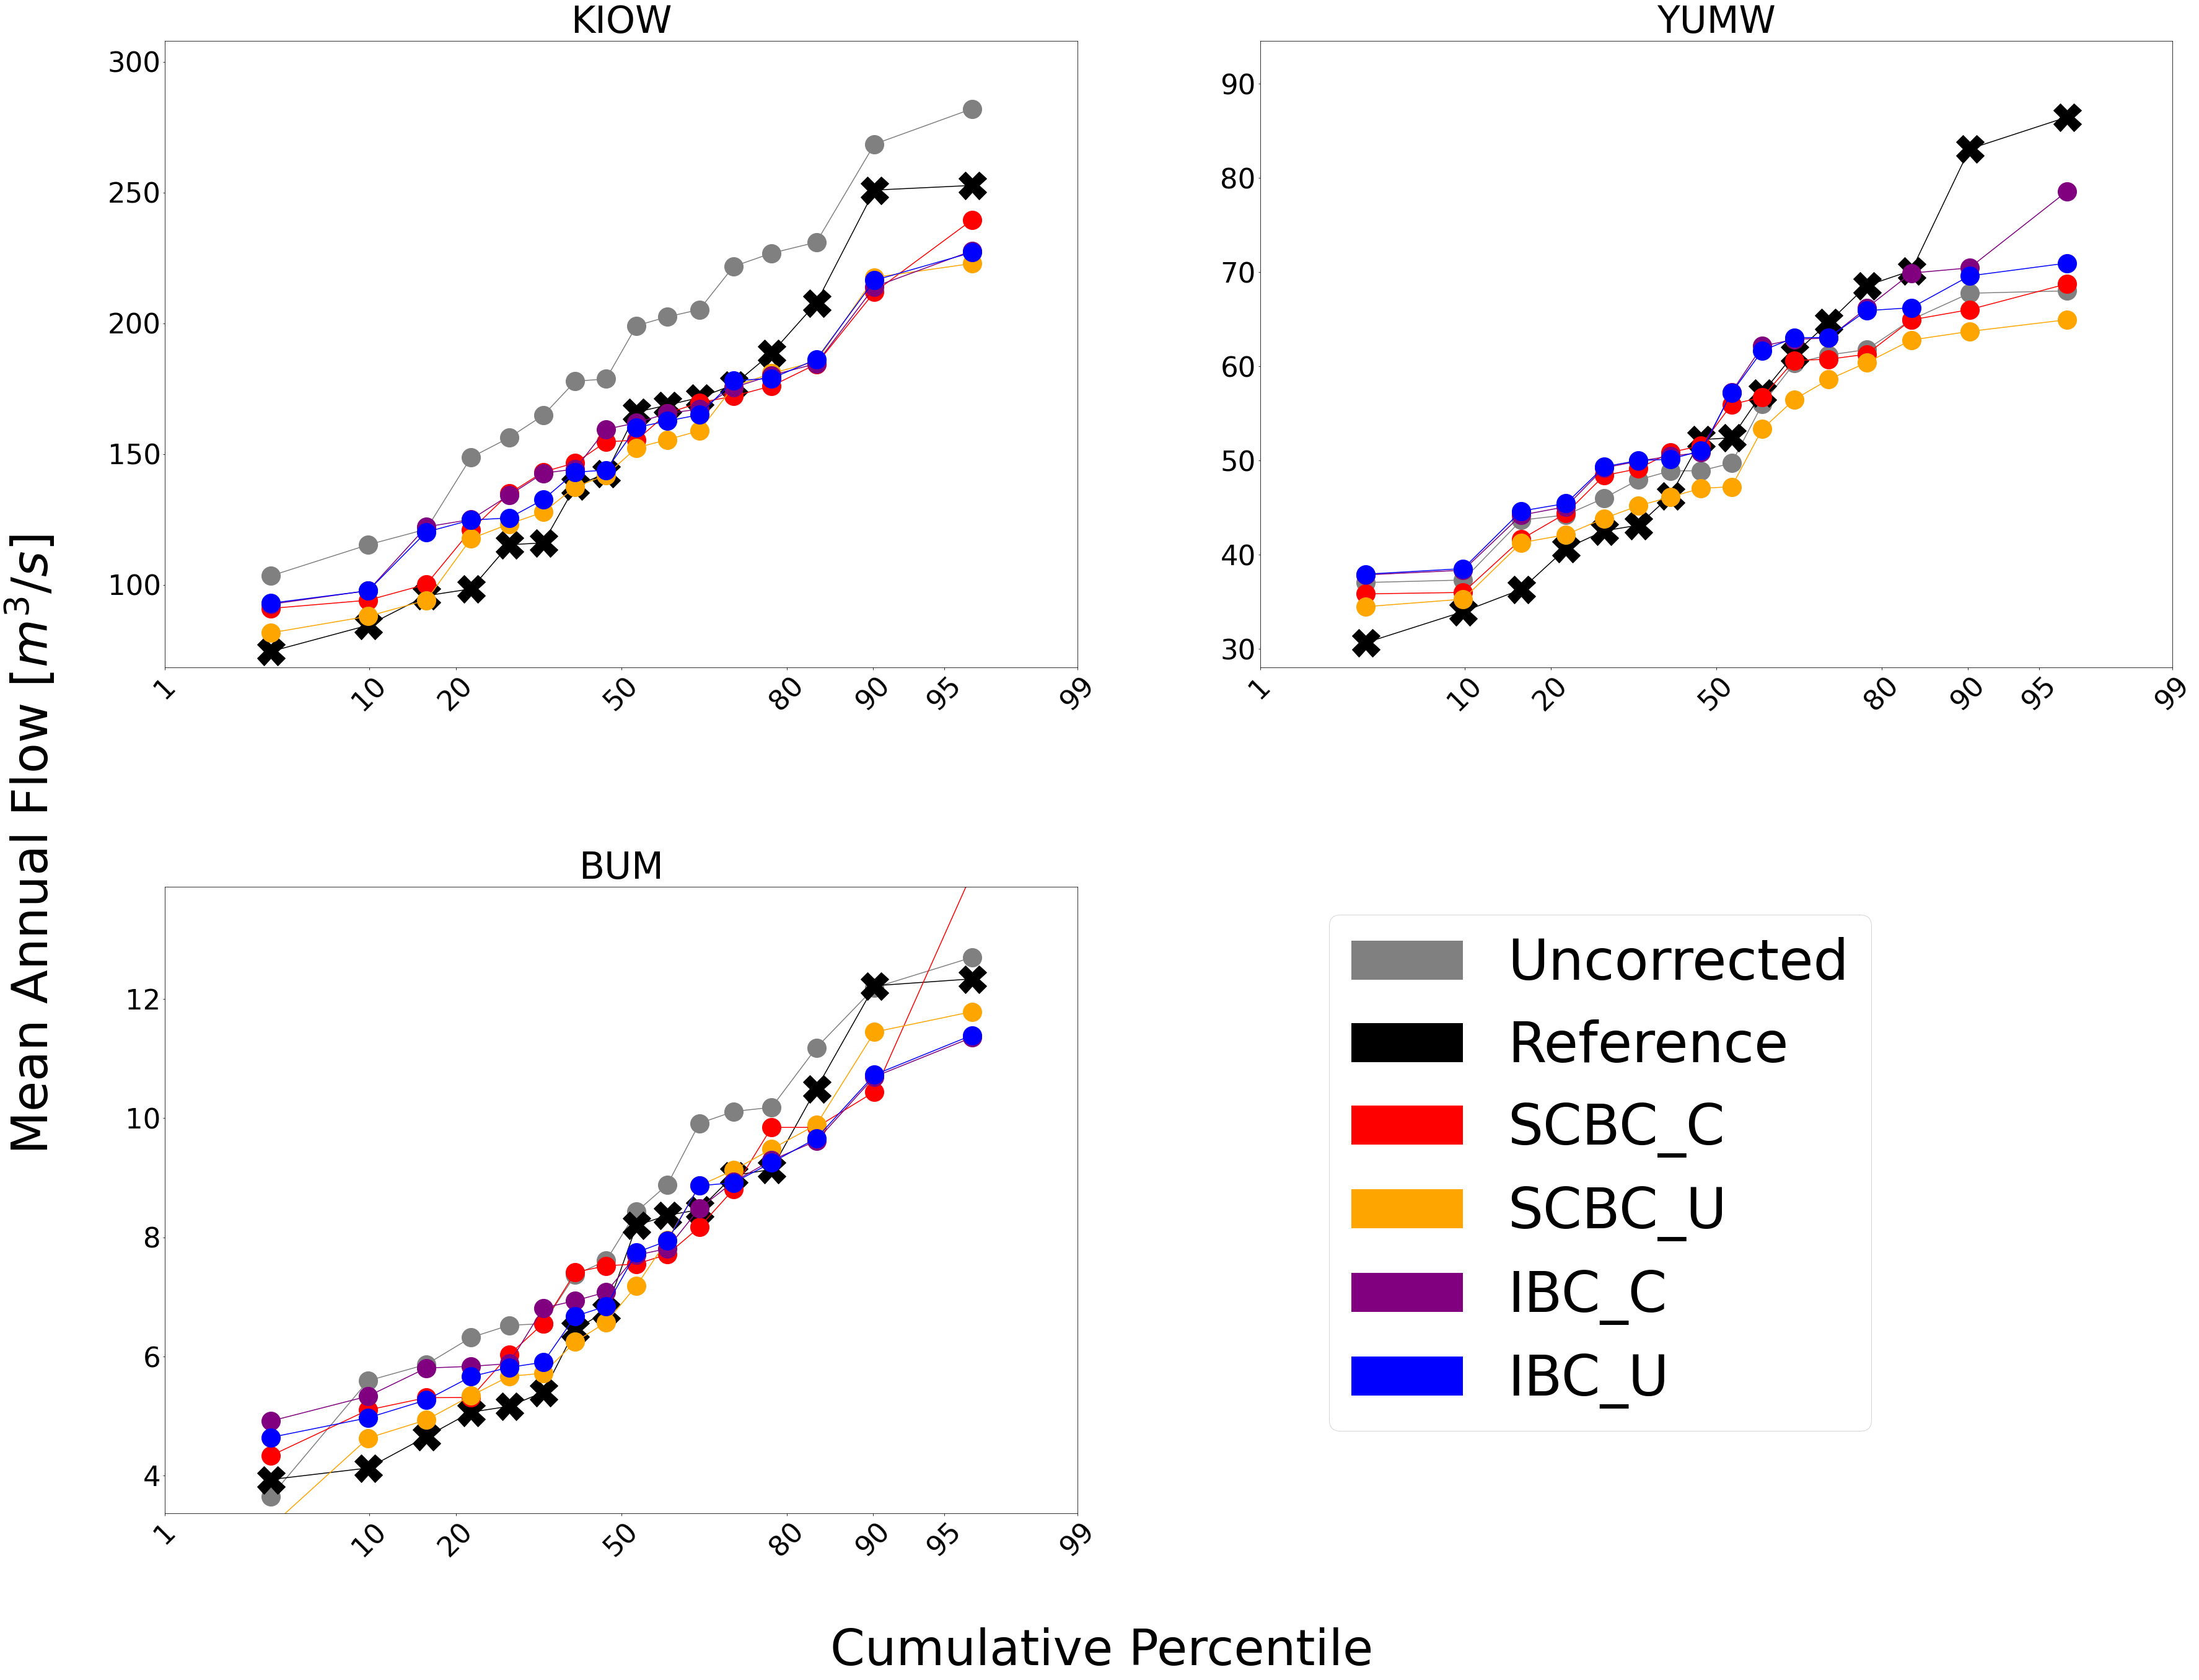

In [35]:
bplot.compare_mean_grouped_CPD(
    flow_dataset= yakima_ds, 
    plot_sites = select_sites,
    grouper_func = bplot.calc_water_year, 
    figsize = (60,40),
    raw_var = 'raw', raw_name = 'Uncorrected',
    ref_var = 'ref', ref_name = 'Reference',
    bc_vars = bcs, bc_names = [bc.upper() for bc in bcs],
    plot_colors = colors,
    linestyles = 2 * ['-','-','-'],
    markers = ['o', 'X', 'o', 'o', 'o', 'o'],
    fontsize_legend = 90,
    legend_bbox_to_anchor = (1.9,1.0)
);

This function is also capable of subsetting data by month should you want to compare only January flows for example. Because ``bmorph`` makes changes based on flow distributions, this plot is the closest to directly analyzing how the different methods correct flows.

### Simple River Network

Finally, we can plot information of the SCBC across the simple river network. Let's look at the difference in the average percent difference for both `SCBC_U` and `SCBC_C`. From the timeseries plots created earlier you might have noticed that the conditional bias corrections produced lower flows in the spring months. We will start by looking only at those months. You might try changing the season if you're interested. 

Text(0.5, 1.0, 'SCBC_C')

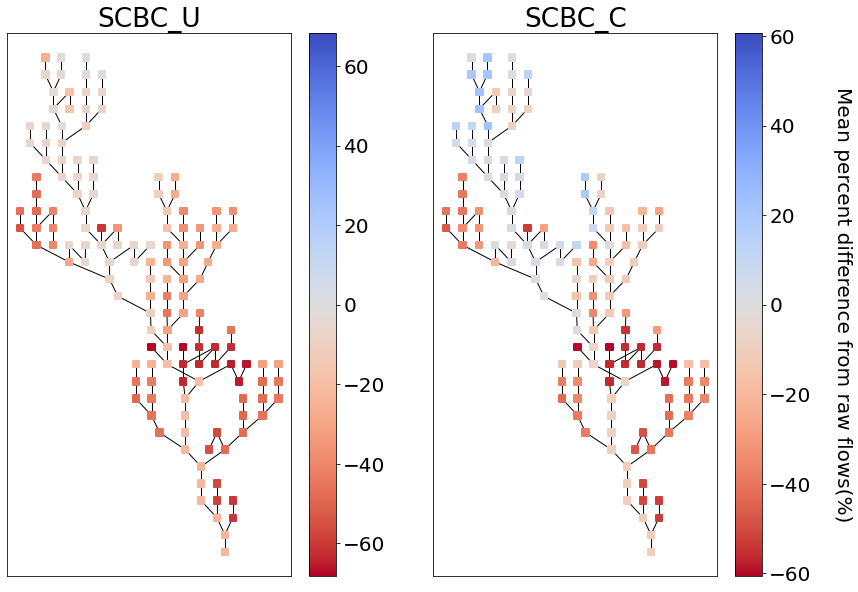

In [61]:
season = 'MAM' # Choose from DJF, MAM, JJA, SON
scbc_c = conditioned_seg_totals['IRFroutedRunoff']
scbc_u = unconditioned_seg_totals['IRFroutedRunoff']
raw = yakima_met_seg['IRFroutedRunoff']
scbc_c_percent_diff = 100 * ((scbc_c-raw)/raw).groupby(scbc_c['time'].dt.season).mean().sel(season=season)
scbc_u_percent_diff = 100 * ((scbc_u-raw)/raw).groupby(scbc_u['time'].dt.season).mean().sel(season=season)

mainstream_map = yakima_srn.generate_mainstream_map()
scbc_u_percent_diff = pd.Series(data=scbc_u_percent_diff.to_pandas().values, index=mainstream_map.index)
scbc_c_percent_diff = pd.Series(data=scbc_c_percent_diff.to_pandas().values, index=mainstream_map.index)

fig, axes = plt.subplots(1, 2, figsize=(14,10))
yakima_srn.draw_network(color_measure=scbc_u_percent_diff, cmap=mpl.cm.get_cmap('coolwarm_r'), node_size=40,
                        with_cbar=True, cbar_labelsize=20, ax=axes[0], cbar_title='')
axes[0].set_title('SCBC_U')
yakima_srn.draw_network(color_measure=scbc_c_percent_diff, cmap=mpl.cm.get_cmap('coolwarm_r'), node_size=40,
                        with_cbar=True, cbar_labelsize=20, ax=axes[1], cbar_title='Mean percent difference from raw flows(%)')
axes[1].set_title('SCBC_C')

From the plot above we can see that the main differences between the two methods was in modifying the headwater flows, which are at higher elevations and receive more precipitation. This aligns with our hypothesis that the daily minimum temperature would provide a good proxy for erros in snow processes.

# Moving forward

In this tutorial you have learned how to set up, perform bias corrections, and analyze them with bmorph. While this tutorial is meant to cover the essentials there are quite a few diversions/alternatives that you could try out before leaving. If you'd like to mess around a bit before moving on. For instance:
- What happens if you conditionally bias correct on a different variable? Try `seasonal_precip`, or even implement a bias correction conditional on the month if you're feeling adventurous!
- How do the smoothing parameters affect the bias corrected flows? Try a wide range of `n_smooth_short`, or try setting `n_smooth_long` to `None` to turn off the correction of the mean trend.
- Try removing half of the gauged sites to see how it affects the spatially-consistent bias correction. You can do this by commenting out (or deleting) some of the entries in `site_to_seg` up at the top.